# WFSS simulation based on grizli software (Brammer)

It requires:
- A file with a list of sources (ID, RA, DEC, Sersic parameters, NIRISS magnitudes)
- A template image
- Model spectra that correspond to the sources in the file

It produces:
- Simulated clear images (one filter at a time)
- Dithered clear images (following the specified pattern)
    - It uses make_dithers_new from Gabe, July 2018
    - It includes current distorsion model
- Both R and C grism images

!! All images are overwritten so carefull with the outroot name !!

!! Update zero points and configuration files if needed !!

In [1]:
from collections import OrderedDict

import os
os.environ["WEBBPSF_PATH"]="/grp/jwst/ote/webbpsf-data"
os.environ["PYSYN_CDBS"]="/grp/hst/cdbs/"
#####if not on site######
#PYSYN_CDBS="/Users/cpacifici/Documents/pysynphot/grp/hst/cdbs/"
#WEBBPSF_PATH="/Users/cpacifici/Documents/webbpsf/webbpsf-data/"
#########################

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
plt.style.use('mystandard')
plt.figure(figsize=(10,10))

from astropy.table import Table
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.units as u
from astropy.modeling import models
from astropy.io import ascii

import stsci.convolve
import reproject
import glob

import webbpsf

import grizli
import grizli.multifit
import grizli.jwst

from jwst.resample import gwcs_blot

import asdf
from asdf import fits_embed

from rotate_CD_matrix import rotate_CD_matrix


/Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96


Couldn't `import sep`.  SExtractor replaced with SEP 
in April 2018.  Install with `pip install sep`.


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



**Zero points.**

(Needs update? Where are these from?)

In [2]:
# AB image zeropoints computed to match the ETC (Feb 21)
ZPs = OrderedDict([('f090w', 28.27100318778076), 
                   ('f115w', 28.329561852474136), 
                   ('f150w', 28.183657683252214), 
                   ('f200w', 28.260233956567966), 
                   ('f140m', 27.39442027680035), 
                   ('f158m', 27.458684529328927)])

pivot = OrderedDict([('f090w', 9009.324775150702),
             ('f115w', 11494.953696000099),
             ('f150w', 14929.433412860893),
             ('f200w', 19925.71415412438),
             ('f140m', 14035.440274803774),
             ('f158m', 15857.162918853444)])

**Fill the necessary info**


In [3]:
#input sources and spectra
source_catalog='./input_files/sources_withstars.cat'
flat_spectrum = False #option to select only flat spectra
seds_file='./input_files/spec_' #path to spectra for now
ra=53.090861
dec=-27.956420
max_mag=26

#instrument setup
filter='f150w'
mag_col='mag_f150w'
pa_aper=0
naxis=(2048,2048)
pix_scale=0.0656
seg_threshold=0.02 # if >0 add to segmentation image
clip_flux=1.e-5
DITHER_X = [0, 10, 10, -10] #in arcsec [0, 0.3270, 0.1635, -0.1635]
DITHER_Y = [0, 10, -10, -10] #in arcsec [0, 0.1645, 0.3948, 0.2961]

#input template and output root
rate_image='./input_files/jw00306001001_02101_00001_nis_rate.fits'
outroot='niriss-sim-sept18-stars-2048'


In [4]:
# source file will be modified to include a column called MAG_AUTO that corresponds to the magnitude in the selected filter.
# (not sure I still need this)
cat = Table.read(source_catalog, format="ascii.commented_header")

cat["MAG_AUTO"] = cat[mag_col]
Table.write(cat, source_catalog, format="ascii.commented_header", overwrite=True)
print("Updated catalog {} for column {}".format(source_catalog,mag_col))

Updated catalog ./input_files/sources_withstars.cat for column mag_f150w


## Step 1

**Make NIRISS image**

a) only ra-dec, rotation, and wcs to add the sources at the right place

In [5]:
# `size` is image dimension in arcsec
hdu = grizli.utils.make_wcsheader(size=naxis[0]*pix_scale, pixscale=pix_scale, get_hdu=True) 

nis_header = hdu.header
nis_header['CRVAL1'] = ra
nis_header['CRVAL2'] = dec

# Rotate image to desired PA 
nis_wcs = pywcs.WCS(nis_header)
cd_rot = rotate_CD_matrix(nis_wcs.wcs.cd, pa_aper)
for i in range(2):
    for j in range(2):
        nis_header['CD{0}_{1}'.format(i+1,j+1)] = cd_rot[i][j]
    
nis_wcs = pywcs.WCS(nis_header)    
nis_wcs.pscale = pix_scale
nis_header['PA_APER'] = pa_aper

nis_header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CRPIX1  =               1024.0                                                  
CRPIX2  =               1024.0                                                  
CRVAL1  =            53.090861                                                  
CRVAL2  =            -27.95642                                                  
CD1_1   = -1.8222222222222E-05                                                  
CD1_2   =                  0.0                                                  
CD2_1   =                  0.0                                                  
CD2_2   = 1.82222222222222E-

b) Load the catalog and find the sources

In [6]:
# Load the catalog, compute detector flux
gfit = Table.read(source_catalog, format='ascii.commented_header')
gfit

id,ra,dec,star_flag,mag_wfc3_f160w,mag_f090w,mag_f115w,mag_f150w,mag_f200w,mag_f140m,mag_f158m,re,n,q,pa,MAG_AUTO
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,53.090861,-27.95642,0,23.26,23.74,23.2,22.98,22.72,22.94,23.03,0.28,0.836,0.82,9.6,22.98
2,53.091,-27.96,0,24.0,24.3,24.1,23.7,23.5,23.65,23.75,0.5,1.0,0.5,10.0,23.7
3,53.089,-27.945,0,22.0,22.8,22.3,21.7,21.5,21.65,21.75,0.8,4.0,0.5,0.0,21.7
4,53.08,-27.97,1,20.0,20.0,20.0,20.0,20.0,20.0,20.0,0.2,5.0,0.0,0.0,20.0
5,53.083,-27.97,1,19.0,19.0,19.0,19.0,19.0,19.0,19.0,0.2,5.0,0.0,0.0,19.0
6,53.077,-27.97,1,18.0,18.0,18.0,18.0,18.0,18.0,18.0,0.2,5.0,0.0,0.0,18.0


In [7]:
object_mag = gfit[mag_col]
ZP = ZPs[filter.lower()]
object_flux = 10**(-0.4*(object_mag-ZP))

# Determine which objects are within the NIRISS FoV
xc, yc = nis_wcs.all_world2pix(gfit['ra'], gfit['dec'], 0)
obj_in_img = (xc > 1) & (yc > 1) & (xc < naxis[0]-1) & (yc < naxis[1]-1) 
obj_in_img &= object_flux > 0

# Point sources and faint sources
stars = obj_in_img & ((gfit['star_flag'] == 1) | (object_mag > max_mag))
star_idx = np.arange(len(gfit))[stars]

# Galaxies
if 're' not in gfit.colnames:
    gals = obj_in_img < -100 # False
else:
    gals = obj_in_img & (~stars) & (object_mag <= max_mag) & (gfit['re'] > 0)
gal_idx = np.arange(len(gfit))[gals]

print("Stars: {}".format(len(star_idx)))
print("Galaxies: {}".format(len(gal_idx)))

Stars: 3
Galaxies: 3


c) Put the sources in the image

In [8]:
# Initialize model image
nis_model = np.zeros(naxis[::-1], dtype=np.float32)
nis_seg = np.zeros(naxis[::-1], dtype=int)
    
# pixel indices
yp, xp = np.indices(naxis[::-1])    
    
# Add star point sources
xpix = np.cast[int](np.round(xc))
ypix = np.cast[int](np.round(yc))
for ix in star_idx:
    nis_model[ypix[ix], xpix[ix]] = object_flux[ix]
    
if seg_threshold > 0:
    Rseg = 5
    for i, ix in enumerate(star_idx):
        print('seg: {0} ({1}/{2})'.format(ix, i, stars.sum()))
        R = np.sqrt((xp-xpix[ix])**2+(yp-ypix[ix])**2)
        clip_seg = (R <= Rseg) & (nis_seg == 0)
        nis_seg[clip_seg] = gfit['id'][ix]
        
# Add Sersic sources
for i, ix in enumerate(gal_idx):
    print('ID: {0} ({1}/{2})'.format(ix, i, gals.sum()))
        
    # Effective radius, in pixels
    re = gfit['re'][ix]/nis_wcs.pscale
    
    se = models.Sersic2D(amplitude=1., r_eff=re, n=gfit['n'][ix],
                         x_0=xc[ix], y_0=yc[ix], ellip=1-gfit['q'][ix],
                         theta=(gfit['pa'][ix]+90-pa_aper)/180*np.pi)
        
    # Normalize to catalog flux
    m = se(xp, yp)
    renorm = object_flux[ix]/m.sum()
    
    if not np.isfinite(renorm):
        continue
            
    # Add to model image
    nis_model += m*renorm
    
    if seg_threshold > 0:
        # Add to segmentation image
        clip_seg = (m*renorm > seg_threshold) & (nis_seg == 0)
        nis_seg[clip_seg] = gfit['id'][ix]


seg: 3 (0/3)
seg: 4 (1/3)
seg: 5 (2/3)
ID: 0 (0/3)
ID: 1 (1/3)
ID: 2 (2/3)


Check image

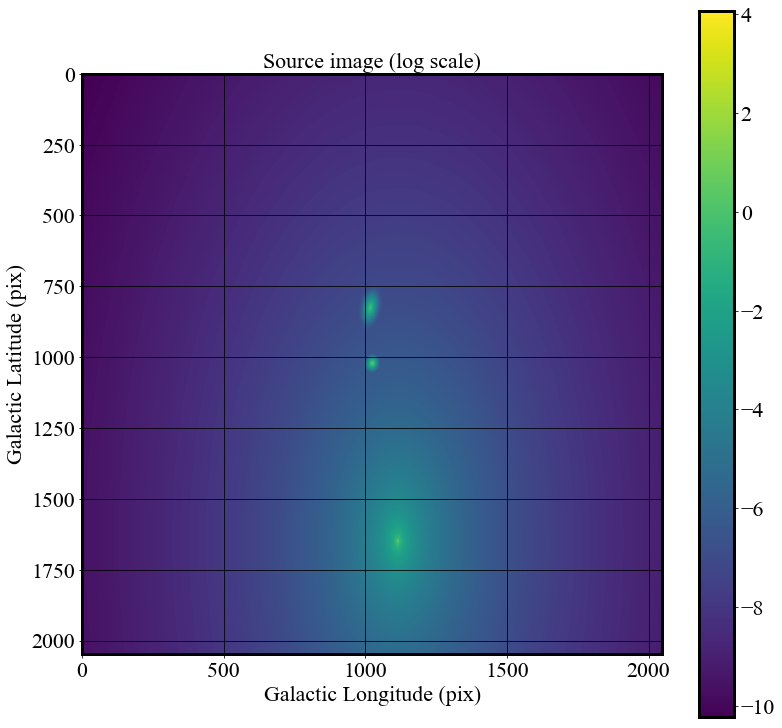

In [9]:
#plt.subplot(projection=pywcs.WCS(nis_header))
plt.figure(figsize=[13,13])
plt.imshow(np.log10(nis_model))
plt.colorbar()
#plt.clim(-10,1)
#plt.imshow(nis_seg)
plt.grid(color='black', ls='solid')
plt.xlabel('Galactic Longitude (pix)')
plt.ylabel('Galactic Latitude (pix)')
plt.title("Source image (log scale)")
plt.xlim(0,naxis[0])
plt.ylim(naxis[1],0)
plt.show()

d) Convolve with NIRISS PSF and save image and segmentation map

In [10]:
nis = webbpsf.NIRISS()

# Add -0.5, -0.5 pixel offset to get convolved image in correct place
nis.options['source_offset_r'] = 0.5*nis_wcs.pscale # offset in arcseconds
nis.options['source_offset_theta'] = 135.   # degrees CCW from +Y

# Get the PSF
nis.filter = filter.upper()
psf_hdu = nis.calcPSF(fov_pixels=64) # power of 2 for fast FFT convolution  
psf = psf_hdu[1].data
psf /= psf.sum()

# Convolve the model image
nis_fullsim = stsci.convolve.convolve2d(nis_model, psf, output=None, mode='nearest', cval=0.0, fft=1)

# Mask low fluxes to make images gzip smaller
#mask = nis_fullsim > clip_flux
#nis_fullsim[~mask] = 0
    
# Save the output image
pyfits.writeto('{0}-{1}.fits'.format(outroot, nis.filter.lower()), 
               data=nis_fullsim, header=nis_header,
               overwrite=True, output_verify='fix')

# Save the segmentation image
if seg_threshold > 0:
    pyfits.writeto('{0}-{1}_seg.fits'.format(outroot, nis.filter.lower()), 
                   data=nis_seg, header=nis_header,
                   overwrite=True, output_verify='fix')


Check image

2018-10-05 11:33:43,176 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until

2018-10-05 11:33:43,177 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until



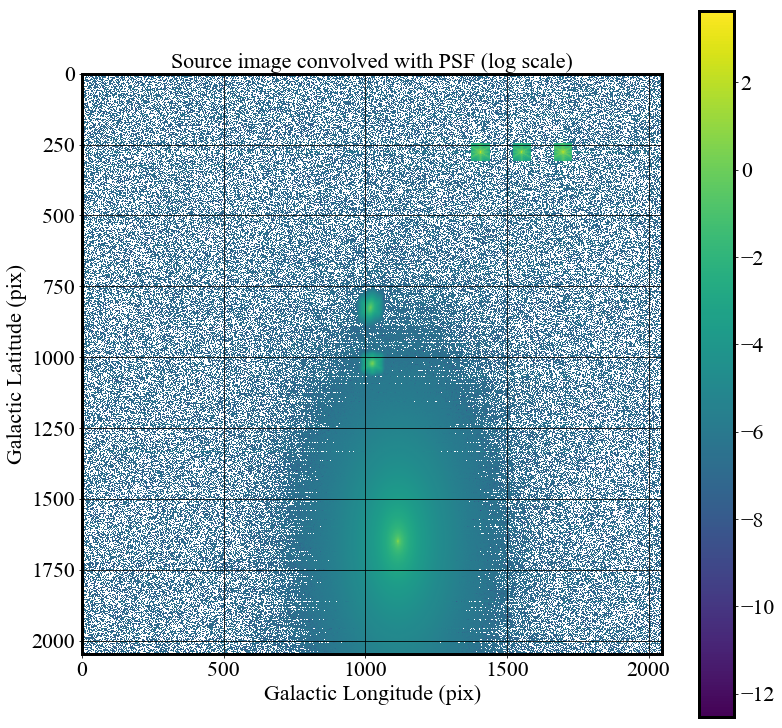

In [11]:
#plt.subplot(projection=pywcs.WCS(nis_header))
plt.figure(figsize=[13,13])
plt.imshow(np.log10(nis_fullsim))
plt.colorbar()
#plt.clim(-10,1)
#plt.imshow(nis_seg)
plt.grid(color='black', ls='solid')
plt.xlabel('Galactic Longitude (pix)')
plt.ylabel('Galactic Latitude (pix)')
plt.title("Source image convolved with PSF (log scale)")
plt.xlim(0,naxis[0])
plt.ylim(naxis[1],0)
plt.show()

## Step 2

**Make the dithered exposures with distortion and empty grism files**

Make four dithered exposures following the standard template pattern or whatever specified pattern.

It reopens image just created and it uses a reference rate image to create the right and complete header.

In [12]:
# Dithers for WFSS (use the sim image just created)
ref = pyfits.open('{0}-{1}.fits'.format(outroot, nis.filter.lower()))
ref_model = grizli.jwst.hdu_to_imagemodel(ref[0])
blot_parent = gwcs_blot.GWCSBlot(ref_model)

# Center position on the image
r0 = ra*u.deg
d0 = dec*u.deg

# 4-point dither pattern, in arcsec
dx = DITHER_X
dy = DITHER_Y

# Rate image from NIRISS Day-in-the-life test
rate_im = pyfits.open(rate_image)
rate_im[0].header['PUPIL'] = filter.upper()

aa = asdf.open(rate_image)
aa['data'] = rate_im['SCI'].data
aa['dq'] = rate_im['DQ'].data
wcsinfo = aa['meta']['wcsinfo']
pointing = aa['meta']['pointing']
inst = aa['meta']['instrument']

#Add photometry information to header
#Possibly ABZP is calculated in model.py - need to double check

rate_im[0].header['ABZP'] = (ZPs[filter.lower()], 'Filter AB zeropoint')
rate_im[0].header['PHOTPLAM'] = (pivot[filter.lower()], 'Filter pivot wavelength')

log_photflam = rate_im[0].header['ABZP'] - 18.6921 + 21.1 + 5*np.log10(rate_im[0].header['PHOTPLAM'])
rate_im[0].header['PHOTFLAM'] = (10**(-0.4*log_photflam), 'Transformation to flambda cgs flux density')

Jy = 10**(-0.4*(ZPs[filter.lower()]-23.9))*1.e-6
rate_im[0].header['PHOTFNU'] = (Jy, 'Transformation to Jansky')
    
fnu_scale = Jy*u.Jy/(0.0656*u.arcsec)**2
rate_im[0].header['DN2MJYSR'] = (fnu_scale.to(u.MJy/u.sr).value, 'Transformation to MJy/steradian')

#Adding PA_V3 just in case this is the reason for crushing
#rate_im[0].header['PA_V3'] = 0
#rate_im['SCI'].header['XPA_V3'] = 0

#Check header
rate_im[0].header


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
                                                                                
        Level 3 Schema Metadata                                                 
                                                                                
DATE    = '2018-06-17T03:42:52.115' / [yyyy-mm-ddThh:mm:ss.ss] UTC date file cre
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
FILENAME= 'jw00306001001_02101_00001_nis_rate.fits' / Name of the file          
FILETYPE= 'uncalibrated'       / Type of data in the file                       
SDP_VER = '2018_1  '        

Position 1, f150w


2018-10-05 11:33:49,218 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11162284856248 -27.975288986234162 53.11217113186253 -27.93784921610773 53.07006399767443 -27.937528702656785 53.06951507125397 -27.974999101062703
2018-10-05 11:33:49,219 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:33:52,219 - stpipe - INFO - Blotting (2048, 2048) <-- (2048, 2048)


niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150r-pos1_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150c-pos1_rate.fits


2018-10-05 11:33:53,995 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10

2018-10-05 11:33:53,996 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10



Position 2, f150w


2018-10-05 11:33:55,625 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.114400192464906 -27.972511208638753 53.114948462512245 -27.935071438522087 53.07284241083851 -27.934750925061994 53.072293499397446 -27.972221323477704
2018-10-05 11:33:55,625 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:33:58,527 - stpipe - INFO - Blotting (2048, 2048) <-- (2048, 2048)


niriss-sim-sept18-stars-2048-f150w-clear-pos2_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150r-pos2_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150c-pos2_rate.fits
Position 3, f150w


2018-10-05 11:34:01,432 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11440126174932 -27.978066763829563 53.11494955830401 -27.94062699369338 53.0728413414469 -27.94030648025158 53.07229240004493 -27.97777687864771
2018-10-05 11:34:01,435 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:04,539 - stpipe - INFO - Blotting (2048, 2048) <-- (2048, 2048)


niriss-sim-sept18-stars-2048-f150w-clear-pos3_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150r-pos3_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150c-pos3_rate.fits
Position 4, f150w


2018-10-05 11:34:07,960 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.10884550473639 -27.978066763829567 53.10939380129107 -27.940626993693378 53.06728558443396 -27.94030648025158 53.06673664303199 -27.977776878647706
2018-10-05 11:34:07,962 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:11,282 - stpipe - INFO - Blotting (2048, 2048) <-- (2048, 2048)


niriss-sim-sept18-stars-2048-f150w-clear-pos4_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150r-pos4_rate.fits
niriss-sim-sept18-stars-2048-f150w-gr150c-pos4_rate.fits


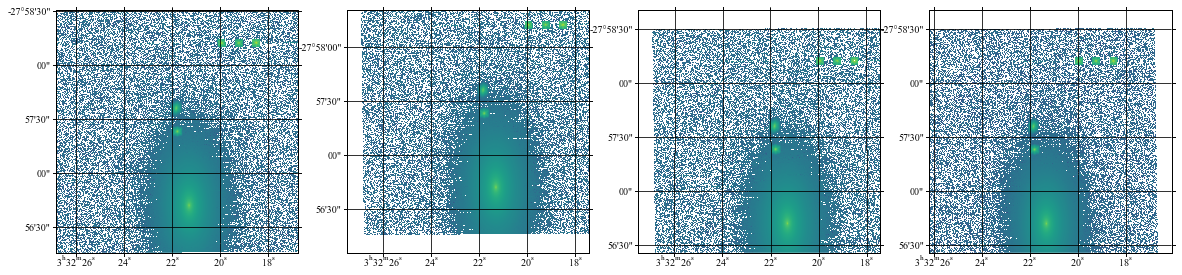

In [13]:
#Make the 4 dithers with distortion

plt.figure(figsize=(20,10))

for pos in range(4):
    print('Position {0}, {1}'.format(pos+1, filter))
    
    inst['filter'] = rate_im[0].header['FILTER'] = 'CLEAR'
    inst['pupil'] = rate_im[0].header['PUPIL'] = filter.upper()
    
    cosd = np.cos(d0/180*np.pi)
    ra = (r0+dx[pos]/cosd*u.arcsec).value
    dec = (d0+dy[pos]*u.arcsec).value
        
    #Update header in rate image and wcf info
    rate_im[1].header['CRVAL1'] = rate_im[1].header['RA_REF'] = ra
    rate_im[1].header['CRVAL2'] = rate_im[1].header['DEC_REF'] = dec
    wcsinfo['crval1'] = wcsinfo['ra_ref'] = pointing['ra_v1'] = ra
    wcsinfo['crval2'] = wcsinfo['dec_ref'] = pointing['dec_v1'] = dec
    
    # Blot reference data to distorted frame
    rate_model = grizli.jwst.img_with_wcs(rate_im)
    blot_child = blot_parent.extract_image(rate_model, interp='poly5')       
    rate_im['SCI'].data = blot_child
    
    # zero-out DQ array
    rate_im['DQ'].data *= 0
    
    #this line makes grizli crush...no idea why
    #rate_im[0].header['TARGNAME'] = aa['meta']['target'] = 'NIS_SIM'
            
    print('{0}-{1}-clear-pos{2}_rate.fits'.format(outroot, filter, pos+1))
    ff = fits_embed.AsdfInFits(rate_im, {'meta':aa['meta']})
    ff.write_to('{0}-{1}-clear-pos{2}_rate.fits'.format(outroot, filter, pos+1), overwrite=True)
            
    # Make grism files (sci extension is direct image for now)
    for grism in ['gr150r', 'gr150c']:
        inst['filter'] = rate_im[0].header['FILTER'] = grism.upper()
        out = '{0}-{1}-{grism}-pos{2}_rate.fits'.format(outroot, filter, pos+1, grism=grism)
        print(out)
        ff = fits_embed.AsdfInFits(rate_im, aa['meta'])
        ff.write_to(out, overwrite=True)
        
    # Show dithered images
    plt.subplot(1,4,pos+1,projection=pywcs.WCS(rate_im['SCI'].header))
    plt.imshow(np.log10(rate_im['SCI'].data))
    plt.grid(color='black', ls='solid')
    #plt.colorbar()
    #plt.xlim(0,naxis[0])
    #plt.ylim(0,naxis[1])

#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')
plt.show()

## Step 3

**Compute the grism model and fill the grism exposures with these models**

Again, it uses the images just created (seg map, direct image, and the placeholder for the grism).
Uses again the catalog file.

It can use:
- flat spectra
- spectra generated with EAZY (have not tested this yet)
- arbitrary spectra (still need to code this one)

In [14]:
# Use the image just created
grism_files = glob.glob('{0}-{1}-gr15*pos*_rate.fits'.format(outroot,nis.filter.lower()))
direct_files = [x.replace("gr150c", "clear") if "gr150c" in x else x.replace("gr150r", "clear") for x in grism_files]*2
g_seg_file = '{0}-{1}_seg.fits'.format(outroot, nis.filter.lower())

grp = grizli.multifit.GroupFLT(grism_files=grism_files,
                                   direct_files=direct_files,
                                   ref_file=None,
                                   seg_file=g_seg_file,
                                   catalog=source_catalog, cpu_count=4)


CAMI: serial


2018-10-05 11:34:17,818 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11162284856248 -27.975288986234162 53.11217113186253 -27.93784921610773 53.07006399767443 -27.937528702656785 53.06951507125397 -27.974999101062703
2018-10-05 11:34:17,819 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:20,387 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11162284856248 -27.975288986234162 53.11217113186253 -27.93784921610773 53.07006399767443 -27.937528702656785 53.06951507125397 -27.974999101062703
2018-10-05 11:34:20,388 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150C.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150c-pos1_rate.fits / Pad ref HDU with 467 pixels
niriss-sim-sept18-stars-2048-f150w-gr150c-pos1_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2018-10-05 11:34:24,928 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.114400192464906 -27.97251120863875 53.114948462512245 -27.935071438522083 53.07284241083851 -27.93475092506199 53.072293499397446 -27.9722213234777
2018-10-05 11:34:24,929 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:27,311 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.114400192464906 -27.97251120863875 53.114948462512245 -27.935071438522083 53.07284241083851 -27.93475092506199 53.072293499397446 -27.9722213234777
2018-10-05 11:34:27,312 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150C.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150c-pos2_rate.fits / Pad ref HDU with 619 pixels
niriss-sim-sept18-stars-2048-f150w-gr150c-pos2_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2018-10-05 11:34:31,428 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11440126174932 -27.978066763829567 53.11494955830401 -27.940626993693385 53.0728413414469 -27.940306480251582 53.07229240004493 -27.977776878647713
2018-10-05 11:34:31,429 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:33,751 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11440126174932 -27.978066763829567 53.11494955830401 -27.940626993693385 53.0728413414469 -27.940306480251582 53.07229240004493 -27.977776878647713
2018-10-05 11:34:33,752 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150C.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150c-pos3_rate.fits / Pad ref HDU with 616 pixels
niriss-sim-sept18-stars-2048-f150w-gr150c-pos3_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2018-10-05 11:34:37,813 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.108845504736394 -27.978066763829567 53.10939380129108 -27.940626993693378 53.06728558443397 -27.940306480251582 53.066736643031994 -27.977776878647706
2018-10-05 11:34:37,814 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:40,401 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.108845504736394 -27.978066763829567 53.10939380129108 -27.940626993693378 53.06728558443397 -27.940306480251582 53.066736643031994 -27.977776878647706
2018-10-05 11:34:40,402 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150C.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150c-pos4_rate.fits / Pad ref HDU with 616 pixels
niriss-sim-sept18-stars-2048-f150w-gr150c-pos4_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2018-10-05 11:34:44,404 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11162284856248 -27.975288986234162 53.11217113186253 -27.93784921610773 53.07006399767443 -27.937528702656785 53.06951507125397 -27.974999101062703
2018-10-05 11:34:44,404 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:46,740 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11162284856248 -27.975288986234162 53.11217113186253 -27.93784921610773 53.07006399767443 -27.937528702656785 53.06951507125397 -27.974999101062703
2018-10-05 11:34:46,741 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150R.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150r-pos1_rate.fits / Pad ref HDU with 467 pixels
niriss-sim-sept18-stars-2048-f150w-gr150r-pos1_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2018-10-05 11:34:50,952 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.114400192464906 -27.97251120863875 53.114948462512245 -27.935071438522083 53.07284241083851 -27.93475092506199 53.072293499397446 -27.9722213234777
2018-10-05 11:34:50,953 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:34:53,473 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.114400192464906 -27.97251120863875 53.114948462512245 -27.935071438522083 53.07284241083851 -27.93475092506199 53.072293499397446 -27.9722213234777
2018-10-05 11:34:53,474 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150R.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150r-pos2_rate.fits / Pad ref HDU with 619 pixels
niriss-sim-sept18-stars-2048-f150w-gr150r-pos2_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2018-10-05 11:34:57,738 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11440126174932 -27.978066763829567 53.11494955830401 -27.940626993693385 53.0728413414469 -27.940306480251582 53.07229240004493 -27.977776878647713
2018-10-05 11:34:57,738 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:35:00,142 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.11440126174932 -27.978066763829567 53.11494955830401 -27.940626993693385 53.0728413414469 -27.940306480251582 53.07229240004493 -27.977776878647713
2018-10-05 11:35:00,143 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150R.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150r-pos3_rate.fits / Pad ref HDU with 616 pixels
niriss-sim-sept18-stars-2048-f150w-gr150r-pos3_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2018-10-05 11:35:04,082 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.108845504736394 -27.978066763829567 53.10939380129108 -27.940626993693378 53.06728558443397 -27.940306480251582 53.066736643031994 -27.977776878647706
2018-10-05 11:35:04,082 - stpipe - INFO - COMPLETED assign_wcs
2018-10-05 11:35:06,295 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.108845504736394 -27.978066763829567 53.10939380129108 -27.940626993693378 53.06728558443397 -27.940306480251582 53.066736643031994 -27.977776878647706
2018-10-05 11:35:06,296 - stpipe - INFO - COMPLETED assign_wcs


CAMI: Configuration file:  /Users/cpacifici/Documents/grizli/CONF/GR150R.F150W.conf
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
niriss-sim-sept18-stars-2048-f150w-gr150r-pos4_rate.fits / Pad ref HDU with 616 pixels
niriss-sim-sept18-stars-2048-f150w-gr150r-pos4_rate.fits / blot segmentation niriss-sim-sept18-stars-2048-f150w_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True
Files loaded - 52.88 sec.


In [15]:
#use default flat spectra or input spectra

if flat_spectrum is True:
    fit_info = None

else:
    fit_info = OrderedDict()
    for i in range (0,len(gal_idx)):
        seds = pd.read_table('{}{:02d}.dat'.format(seds_file,gfit['id'][i]),sep='\s+')
        print("Using file {}".format(seds_file+'{:02d}.dat'.format(gfit['id'][i])))
        seds_clip = seds[(seds['wave']>5000.) & (seds['wave']<35000.)]
        sedwave = seds_clip['wave'].values
        sedflux = seds_clip['f_lam'].values
        fit_info[gfit['id'][i]] = {'mag':-1, 'spec':[sedwave, sedflux]}


Using file ./input_files/spec_01.dat
Using file ./input_files/spec_02.dat
Using file ./input_files/spec_03.dat


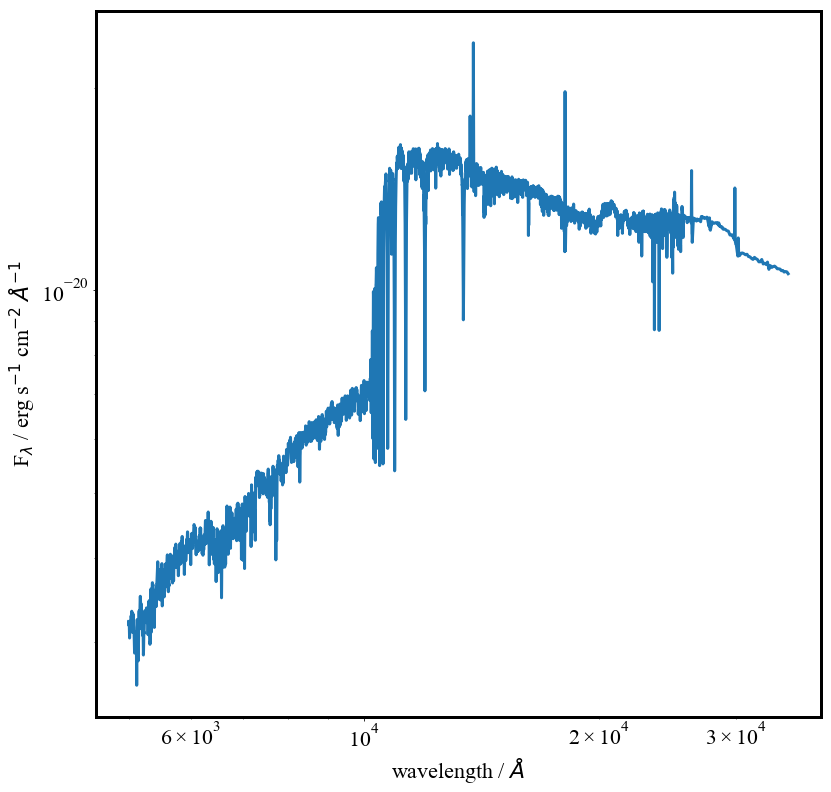

In [16]:
#show one of the spectra if flat_spectrum is false
if flat_spectrum==False:
    whichgal = 3

    plt.figure(figsize=[13,13])
    plt.loglog(fit_info[whichgal]['spec'][0],fit_info[whichgal]['spec'][1])
    plt.xlabel("wavelength / $\AA$")
    plt.ylabel("F$_\lambda$ / erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$")
    plt.show()

In [17]:
#Use flat spectra?
if flat_spectrum is True:
    print('Compute all objects to AB<chosen mag limit, flat spectrum')
    grp.compute_full_model(fit_info=None, verbose=False, store=False, mag_limit=max_mag, coeffs=[1], cpu_count=0)

else:
    #Add galaxy SEDs for brighter objects
    print('Compute galaxies to AB<chosen mag limit (N={0})'.format(len(fit_info)))
    grp.compute_full_model(fit_info=fit_info, verbose=False, store=False, mag_limit=max_mag, coeffs=[1], cpu_count=0)

# Put the models into the grism FITS exposure files
for i in range(len(grism_files)):
    if grp.FLTs[i].is_rotated:
        grp.FLTs[i].transform_NIRISS(verbose=False)
            
    im = pyfits.open(grism_files[i], mode='update')
    pad = grp.FLTs[i].pad
    im['SCI'].data = grp.FLTs[i].model[pad:-pad, pad:-pad]
    im.flush()
    
    # Rotate back
    grp.FLTs[i].transform_NIRISS(verbose=False)


Compute galaxies to AB<chosen mag limit (N=3)


2018-10-05 11:35:15,780 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150c-pos1_rate.fits: _compute_model Done


2018-10-05 11:35:21,293 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150c-pos2_rate.fits: _compute_model Done


2018-10-05 11:35:26,949 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150c-pos3_rate.fits: _compute_model Done


2018-10-05 11:35:35,704 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150c-pos4_rate.fits: _compute_model Done


2018-10-05 11:35:41,445 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150r-pos1_rate.fits: _compute_model Done


2018-10-05 11:35:48,133 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150r-pos2_rate.fits: _compute_model Done


2018-10-05 11:35:52,664 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150r-pos3_rate.fits: _compute_model Done


2018-10-05 11:35:58,307 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



niriss-sim-sept18-stars-2048-f150w-gr150r-pos4_rate.fits: _compute_model Done


Check grism image

2018-10-05 11:36:03,840 - stpipe - WARNING - /Users/cpacifici/miniconda3/envs/jwpsf/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until



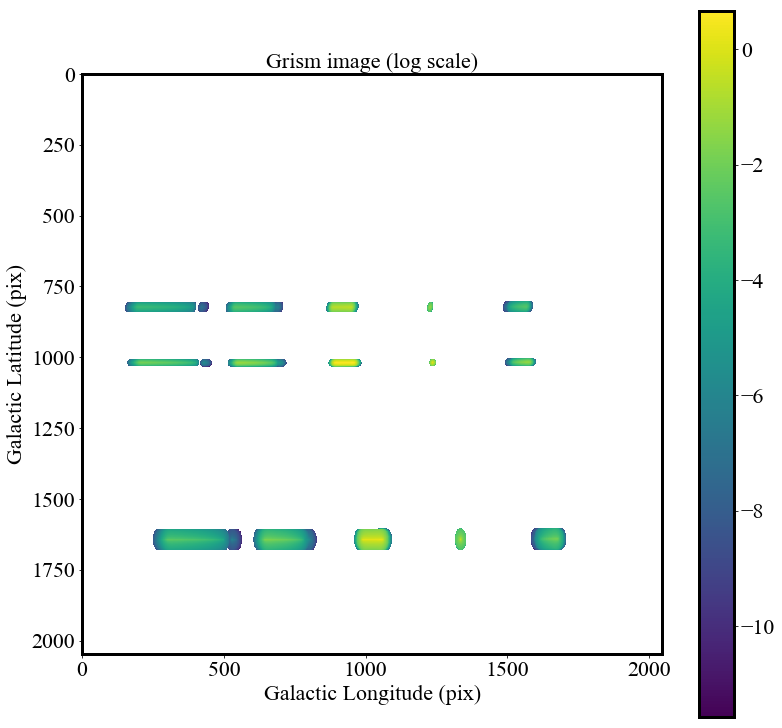

In [18]:
hdu = pyfits.open('{0}-{1}-gr150c-pos1_rate.fits'.format(outroot,filter))
plt.figure(figsize=[13,13])
plt.imshow(np.log10(hdu['SCI'].data))
#plt.imshow(hdu['SCI'].data)
plt.colorbar()
plt.xlabel('Galactic Longitude (pix)')
plt.ylabel('Galactic Latitude (pix)')
plt.title("Grism image (log scale)")
plt.show()